In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pymsm.datasets import prep_covid_hosp_data
from pymsm.multi_state_competing_risks_model import MultiStateModel
from pymsm.plotting import stackplot_state_timesteps_from_paths
from pymsm.statistics import (
    prob_visited_states,
    stats_total_time_at_states,
    get_path_frequencies,
    path_total_time_at_states
)
from pymsm.simulation import MultiStateSimulator

pd.set_option("display.max_rows", 100)
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Load Covid hospitalization data set  
raw public data available at https://github.com/JonathanSomer/covid-19-multi-state-model/blob/master/data/data_for_paper.csv

In [35]:
covid_dataset = prep_covid_hosp_data()

# Some path definitions
# covariate_cols = ["is_male", "age", "was_severe", "cum_hosp_time"]
covariate_cols = ["is_male", "age", "was_severe"]

states_labels_long = {
    0: "Censored",
    1: "Discharged\Recovered",
    2: "Mild or Moderate",
    3: "Severe",
    4: "Deceased",
}
states_labels = {0: "C", 1: "R", 2: "M", 3: "S", 4: "D"}
terminal_states = [4]


100%|██████████| 2675/2675 [00:04<00:00, 595.64it/s]


Let's look at one patients path

In [36]:
covid_dataset[567].print_path()

Sample id: 577
States: [2 3 4]
Transition times: [ 6 31]
Covariates:
is_male        1.0
age           72.5
was_severe     0.0
Name: 567, dtype: float64


Path frequencies for all different trajectories in the data

In [37]:
path_freqs = get_path_frequencies(covid_dataset, states_labels)
print(path_freqs)

M->R                               1906
M                                   202
M->S                                 76
S->D                                 74
M->S->D                              59
M->S->M->R                           46
M->D                                 44
M->R->M->R                           42
S                                    42
M->R->M                              36
M->S->M                              35
S->M->R                              28
S->M                                 27
M->S->M->S                            8
S->R                                  6
S->M->S                               5
S->M->S->M->R                         3
S->M->D                               3
M->S->M->S->M                         3
M->S->M->S->M->R                      3
M->R->M->R->M->R                      3
M->S->R                               3
S->M->S->D                            2
M->S->M->D                            2
M->R->M->S                            2


# Fitting the Multistate model

In [38]:
def covid_update_covariates_function(
    covariates_entering_origin_state,
    origin_state=None,
    target_state=None,
    time_at_origin=None,
    abs_time_entry_to_target_state=None,
):
    covariates = covariates_entering_origin_state.copy()

    # update is_severe covariate
    if origin_state == 3:
        covariates['was_severe'] = 1

    # # update cum_hosp_tim covariate
    # if ((origin_state==2) & (origin_state==3)):
    #     covariates["cum_hosp_time"] += time_at_origin

    return covariates


multi_state_model = MultiStateModel(
    covid_dataset, terminal_states, covid_update_covariates_function, covariate_cols,
)


multi_state_model.fit()


Fitting Model at State: 2
>>> Fitting Transition to State: 1, n events: 2135
>>> Fitting Transition to State: 3, n events: 275
>>> Fitting Transition to State: 4, n events: 52
Fitting Model at State: 1
>>> Fitting Transition to State: 2, n events: 98
>>> Fitting Transition to State: 3, n events: 2
Fitting Model at State: 3
>>> Fitting Transition to State: 2, n events: 193


/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column is_male have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'is_male'].var())
>>> print(df.loc[~events, 'is_male'].var())

A very low variance means that the column is_male completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.537. This may imply non-unique solutions to the maximum likelihood. Perha

>>> Fitting Transition to State: 1, n events: 9
>>> Fitting Transition to State: 4, n events: 135


/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/utils/__init__.py:1123: ConvergenceWarning: Column was_severe have very low variance when conditioned on death event present or not. This may harm convergence. This could be a form of 'complete separation'. For example, try the following code:

>>> events = df['target_state'].astype(bool)
>>> print(df.loc[events, 'was_severe'].var())
>>> print(df.loc[~events, 'was_severe'].var())

A very low variance means that the column was_severe completely determines whether a subject dies or not. See https://stats.stackexchange.com/questions/11109/how-to-deal-with-perfect-separation-in-logistic-regression.

  warnings.warn(dedent(warning_text), ConvergenceWarning)
/home/hagair/anaconda3/envs/pymsm/lib/python3.9/site-packages/lifelines/fitters/coxph_fitter.py:1594: ConvergenceWarning: Newton-Rhaphson convergence completed successfully but norm(delta) is still high, 0.262. This may imply non-unique solutions to the maximum likel

# Single patient stats  
Let's take a look at how the model models transitions for a single patient - a female aged 75  
We'll run a Monte-Carlo simulation for 100 samples and present some path statistics

In [41]:
# Run MC for a sample single patient
mc_paths = multi_state_model.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male":0, "age":75, "was_severe":0}),
    origin_state=2,
    current_time=0,
    n_random_samples=100,
    max_transitions=10,
    print_paths=False,
    n_jobs=-1
)

100%|██████████| 100/100 [00:47<00:00,  2.09it/s]


Let's calculate the probability of being in any of the states and also obtain stats regarding time i each state

In [42]:
# Probability of visiting any of the states
for state, state_label in states_labels_long.items():
    if state == 0:
        continue
    print(
        f"Probabilty of ever being {state_label} = {prob_visited_states(mc_paths, states=[state])}"
    )


# Stats for times at states
dfs = []
for state, state_label in states_labels_long.items():
    if state == 0 or state in terminal_states:
        continue
    dfs.append(
        pd.DataFrame(
            data=stats_total_time_at_states(mc_paths, states=[state]),
            index=[state_label],
        )
    )
pd.concat(dfs).round(3).T


Probabilty of ever being Discharged\Recovered = 0.07
Probabilty of ever being Mild or Moderate = 1.0
Probabilty of ever being Severe = 0.31
Probabilty of ever being Deceased = 1.0


,Discharged\Recovered,Mild or Moderate,Severe
time_in_state_mean,2.430,3.830,0.910
time_in_state_std,10.421,2.379,2.164
time_in_state_median,0.000,3.000,0.000
time_in_state_min,0.000,1.000,0.000
time_in_state_max,62.000,15.000,10.000
time_in_state_quantile_0.1,0.000,1.000,0.000
time_in_state_quantile_0.25,0.000,2.000,0.000
time_in_state_quantile_0.75,0.000,5.000,0.000
time_in_state_quantile_0.9,0.000,6.100,3.100


Print out the path frequences for the sampled paths

In [43]:
path_freqs = get_path_frequencies(mc_paths, states_labels)
path_freqs.head(10)

M->D          64
M->S->D       29
M->R->M->D     5
M->R->S->D     2
dtype: int64

A CDF for the total time in hospital

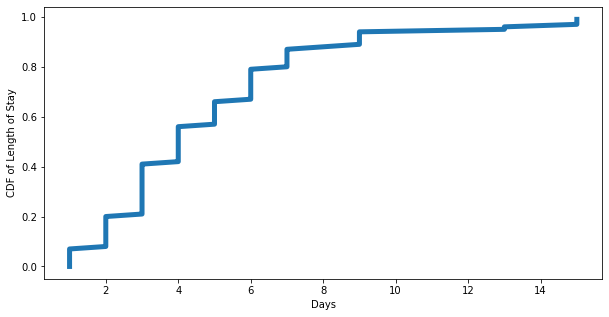

In [47]:
los = np.array([path_total_time_at_states(path, states = [2,3]) for path in mc_paths])

fig, ax = plt.subplots(1,1, figsize=(10,5))
ax.plot(np.sort(los), np.linspace(0, 1, len(los), endpoint=False), lw=5)
# ax.set_xlim(0,20)
ax.set_ylabel('CDF of Length of Stay')
ax.set_xlabel('Days');

# Saving the model and configuring a simulator  
We can save the model for later use, and configure a simulator to generate simulated paths

In [45]:
from pymsm.simulation import extract_competing_risks_models_list_from_msm

# Extract competing risk models list from the model trained
competing_risks_models_list = extract_competing_risks_models_list_from_msm(
    multi_state_model, verbose=True
)

2 1 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f87e22d3dc0>
2 3 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f87e22d3820>
2 4 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f87e2234fd0>
1 2 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f87e2a5f160>
1 3 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f87e2355100>
3 2 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f87e222e6d0>
3 1 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f87e2228d30>
3 4 <pymsm.competing_risks_model.EventSpecificModel object at 0x7f87e2257580>


In [46]:
# Configure the simulator
mssim = MultiStateSimulator(
    competing_risks_models_list,
    terminal_states=terminal_states,
    update_covariates_fn=covid_update_covariates_function,
    covariate_names=covariate_cols,
)


# Run simulation
sim_mc_paths = mssim.run_monte_carlo_simulation(
    sample_covariates=pd.Series({"is_male": 0, "age": 75, "was_severe":0}),
    origin_state=1,
    current_time=0,
    n_random_samples=10,
    max_transitions=10,
    print_paths=True,
)


100%|██████████| 10/10 [00:00<00:00, 3713.75it/s]

States: [1, 2, 4]
Transition times: [31.00007411206493, 4.999963446230332]


States: [1, 2, 4]
Transition times: [5.000066380452762, 4.999981000530078]


States: [1, 3, 4]
Transition times: [22.000058058835027, 1.9999575406170074]


States: [1, 2, 4]
Transition times: [60.00005264026609, 0.999947359733909]


States: [1, 3, 4]
Transition times: [22.000058058835027, 1.9999805514287523]


States: [1, 2, 4]
Transition times: [60.00005264026609, 0.999947359733909]


States: [1, 3, 4]
Transition times: [24.000072609133372, 0.9999842217269617]


States: [1, 2, 4]
Transition times: [65.0, 5.554317056066793e-05]


States: [1, 2, 4]
Transition times: [54.000094461421945, 0.9999121395624684]


States: [1, 2, 4]
Transition times: [37.00006220867002, 14.000030744244398]


